## Analisis Anomali Detection Motor XX

### 1. Data Loading

In [35]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [36]:
# Loading Data
df = pd.read_csv("train_7kwh.csv")

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

df.head(100)

,Time,Frequency reference,Output frequency,Output current,Output voltage,Output power,DC bus voltage,Output frequency after soft-start,Fault output,During Run,Power Supply Voltage,Power Supply Frequency,Electric Power (kWh),Cooling fin temperature,Peak Voltage Output Frequency,Motor q-Axis Current during Fault,Fin Temperature
0,40242.435,20.0,20.0,9.79,162.4,0.2,600.0,20.0,0.0,1.0,399.0,49.9,240.0,37.0,20.0,-17.4,46.0
1,40242.581,20.0,20.0,9.70,162.9,0.5,600.0,20.0,0.0,1.0,399.0,49.9,240.0,37.0,20.0,-17.4,46.0
2,40242.717,20.0,20.0,8.38,155.1,0.0,607.0,20.0,0.0,1.0,399.0,49.9,240.0,37.0,20.0,-17.4,46.0
3,40242.856,20.0,20.0,8.98,155.6,0.1,603.0,20.0,0.0,1.0,399.0,50.0,240.0,37.0,20.0,-17.4,46.0
4,40243.007,20.0,20.0,8.84,155.2,0.4,597.0,20.0,0.0,1.0,399.0,50.0,240.0,37.0,20.0,-17.4,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,40260.614,20.0,20.0,11.11,163.0,0.4,588.0,20.0,0.0,1.0,400.0,50.0,240.0,37.0,20.0,-17.4,46.0
96,40260.862,20.0,20.0,9.21,154.2,-0.9,588.0,20.0,0.0,1.0,400.0,50.0,240.0,37.0,20.0,-17.4,46.0
97,40261.112,20.0,20.0,11.14,159.0,0.0,585.0,20.0,0.0,1.0,399.0,50.0,240.0,37.0,20.0,-17.4,46.0
98,40261.362,20.0,20.0,9.31,153.6,-0.9,588.0,20.0,0.0,1.0,399.0,50.0,240.0,37.0,20.0,-17.4,46.0


In [37]:
# Kolom baru
df['RPM ref'] = df['Frequency reference'] * 120 / 2
df['RPM out'] = df['Output frequency'] * 120 / 2
df['Power Factor'] = (df['Output power'] * 1000) / (np.sqrt(3) * df['Output voltage'] * df['Output current'])
df['Slip (%)'] = (abs(df['RPM out'] - df['RPM ref']) / df['RPM out']) * 100
df['Daya Semu (kVA)'] = (np.sqrt(3) * df['Output voltage'] * df['Output current']) / 1000
df['Efficiency (%)'] = 93.5
df['Daya Output Motor (kW)'] = (np.sqrt(3) * df['Output voltage'] * df['Output current'] * df['Efficiency (%)'] / 100 * df['Power Factor']) / 1000
df['Torque (Nm)'] = 5250*746*1.356/df['RPM out']
df.head(100)

,Time,Frequency reference,Output frequency,Output current,Output voltage,Output power,DC bus voltage,Output frequency after soft-start,Fault output,During Run,...,Motor q-Axis Current during Fault,Fin Temperature,RPM ref,RPM out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,40242.435,20.0,20.0,9.79,162.4,0.2,600.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.072627,0.0,2.753781,93.5,0.1870,4425.645
1,40242.581,20.0,20.0,9.70,162.9,0.5,600.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.182691,0.0,2.736865,93.5,0.4675,4425.645
2,40242.717,20.0,20.0,8.38,155.1,0.0,607.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.000000,0.0,2.251212,93.5,0.0000,4425.645
3,40242.856,20.0,20.0,8.98,155.6,0.1,603.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.041319,0.0,2.420174,93.5,0.0935,4425.645
4,40243.007,20.0,20.0,8.84,155.2,0.4,597.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.168328,0.0,2.376318,93.5,0.3740,4425.645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,40260.614,20.0,20.0,11.11,163.0,0.4,588.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.127526,0.0,3.136623,93.5,0.3740,4425.645
96,40260.862,20.0,20.0,9.21,154.2,-0.9,588.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,-0.365879,0.0,2.459827,93.5,-0.8415,4425.645
97,40261.112,20.0,20.0,11.14,159.0,0.0,585.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.000000,0.0,3.067912,93.5,0.0000,4425.645
98,40261.362,20.0,20.0,9.31,153.6,-0.9,588.0,20.0,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,-0.363363,0.0,2.476860,93.5,-0.8415,4425.645


In [38]:
# Cek apakah ada duplikasi
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

# Hapus data duplikat
df = df.drop_duplicates()

Jumlah data duplikat: 0


In [39]:
# Cek apakah ada data kosong
print(f"Jumlah data kosong: {df.isnull().sum()}")

Jumlah data kosong: Time                                  0
Frequency reference                   0
Output frequency                      0
Output current                        0
Output voltage                        0
Output power                          0
DC bus voltage                        0
Output frequency after soft-start     0
Fault output                          0
During Run                            0
Power Supply Voltage                  0
Power Supply Frequency                0
Electric Power (kWh)                  0
Cooling fin temperature               0
Peak Voltage Output Frequency         0
Motor q-Axis Current during Fault     0
Fin Temperature                       0
RPM ref                               0
RPM out                               0
Power Factor                         30
Slip (%)                             11
Daya Semu (kVA)                       0
Efficiency (%)                        0
Daya Output Motor (kW)               30
Torque (Nm)         

In [40]:
baris_kosong = df[df.isnull().any(axis=1)]

baris_kosong

,Time,Frequency reference,Output frequency,Output current,Output voltage,Output power,DC bus voltage,Output frequency after soft-start,Fault output,During Run,...,Motor q-Axis Current during Fault,Fin Temperature,RPM ref,RPM out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
1010,40947.430,10.0,0.0,0.0,0.0,0.0,849.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1011,40948.522,10.0,0.0,0.0,0.0,0.0,730.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1012,40949.607,10.0,0.0,0.0,0.0,0.0,598.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1013,40950.695,10.0,0.0,0.0,0.0,0.0,575.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1014,40951.778,10.0,0.0,0.0,0.0,0.0,576.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1015,40952.871,10.0,0.0,0.0,0.0,0.0,577.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1016,40953.958,10.0,0.0,0.0,0.0,0.0,575.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1017,40955.044,10.0,0.0,0.0,0.0,0.0,576.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1018,40956.137,10.0,0.0,0.0,0.0,0.0,576.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf
1019,40957.221,10.0,0.0,0.0,0.0,0.0,575.0,0.0,0.0,0.0,...,-17.4,46.0,600.0,0.0,NaN,inf,0.0,93.5,NaN,inf


In [45]:
train = df.dropna()
train

,Time,Frequency reference,Output frequency,Output current,Output voltage,Output power,DC bus voltage,Output frequency after soft-start,Fault output,During Run,...,Motor q-Axis Current during Fault,Fin Temperature,RPM ref,RPM out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,40242.435,20.0,20.00,9.79,162.4,0.2,600.0,20.00,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.072627,0.000000,2.753781,93.5,0.1870,4425.645000
1,40242.581,20.0,20.00,9.70,162.9,0.5,600.0,20.00,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.182691,0.000000,2.736865,93.5,0.4675,4425.645000
2,40242.717,20.0,20.00,8.38,155.1,0.0,607.0,20.00,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.000000,0.000000,2.251212,93.5,0.0000,4425.645000
3,40242.856,20.0,20.00,8.98,155.6,0.1,603.0,20.00,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.041319,0.000000,2.420174,93.5,0.0935,4425.645000
4,40243.007,20.0,20.00,8.84,155.2,0.4,597.0,20.00,0.0,1.0,...,-17.4,46.0,1200.0,1200.0,0.168328,0.000000,2.376318,93.5,0.3740,4425.645000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,40942.005,10.0,10.00,9.74,83.3,0.1,610.0,10.00,0.0,1.0,...,-17.4,46.0,600.0,600.0,0.071160,0.000000,1.405286,93.5,0.0935,8851.290000
1006,40943.091,10.0,10.00,9.22,80.5,0.1,602.0,10.00,0.0,1.0,...,-17.4,46.0,600.0,600.0,0.077788,0.000000,1.285545,93.5,0.0935,8851.290000
1007,40944.170,10.0,10.00,8.45,79.9,0.2,605.0,10.00,0.0,1.0,...,-17.4,46.0,600.0,600.0,0.171027,0.000000,1.169403,93.5,0.1870,8851.290000
1008,40945.253,10.0,8.84,8.59,70.4,0.5,608.0,8.64,0.0,1.0,...,-17.4,46.0,600.0,530.4,0.477357,13.122172,1.047433,93.5,0.4675,10012.771493


In [46]:
train.describe()

,Time,Frequency reference,Output frequency,Output current,Output voltage,Output power,DC bus voltage,Output frequency after soft-start,Fault output,During Run,...,Motor q-Axis Current during Fault,Fin Temperature,RPM ref,RPM out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.0,1010.0,...,1.010000e+03,1010.0,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.0,1010.000000,1010.000000
mean,40507.548675,34.900990,34.924436,7.716881,267.812178,0.208020,607.897030,34.925000,0.0,1.0,...,-1.740000e+01,46.0,2094.059406,2095.466139,0.059714,0.668676,3.443465,93.5,0.194499,2844.490198
std,209.638632,10.970729,10.945930,1.062055,81.940618,0.505377,30.207989,10.946988,0.0,0.0,...,1.386245e-13,0.0,658.243719,656.755794,0.158191,7.361608,0.665877,0.0,0.472528,1253.711030
min,40242.435000,10.000000,3.390000,5.610000,30.800000,-1.000000,577.000000,3.190000,0.0,1.0,...,-1.740000e+01,46.0,600.000000,203.400000,-0.383922,0.000000,0.617760,93.5,-0.935000,1770.258000
25%,40313.531500,30.000000,30.000000,6.902500,228.600000,-0.200000,591.000000,30.000000,0.0,1.0,...,-1.740000e+01,46.0,1800.000000,1800.000000,-0.061688,0.000000,3.104585,93.5,-0.187000,1770.258000
50%,40466.488500,30.000000,30.000000,7.890000,231.850000,0.200000,602.000000,30.000000,0.0,1.0,...,-1.740000e+01,46.0,1800.000000,1800.000000,0.060593,0.000000,3.289623,93.5,0.187000,2950.430000
75%,40673.198500,50.000000,50.000000,8.210000,380.500000,0.600000,611.000000,50.000000,0.0,1.0,...,-1.740000e+01,46.0,3000.000000,3000.000000,0.169077,0.000000,4.020128,93.5,0.561000,2950.430000
max,40946.344000,50.000000,50.000000,11.580000,381.000000,1.900000,710.000000,50.000000,0.0,1.0,...,-1.740000e+01,46.0,3000.000000,3000.000000,0.686350,194.985251,4.783102,93.5,1.776500,26110.000000


### 2. Exploratory Data Analysis

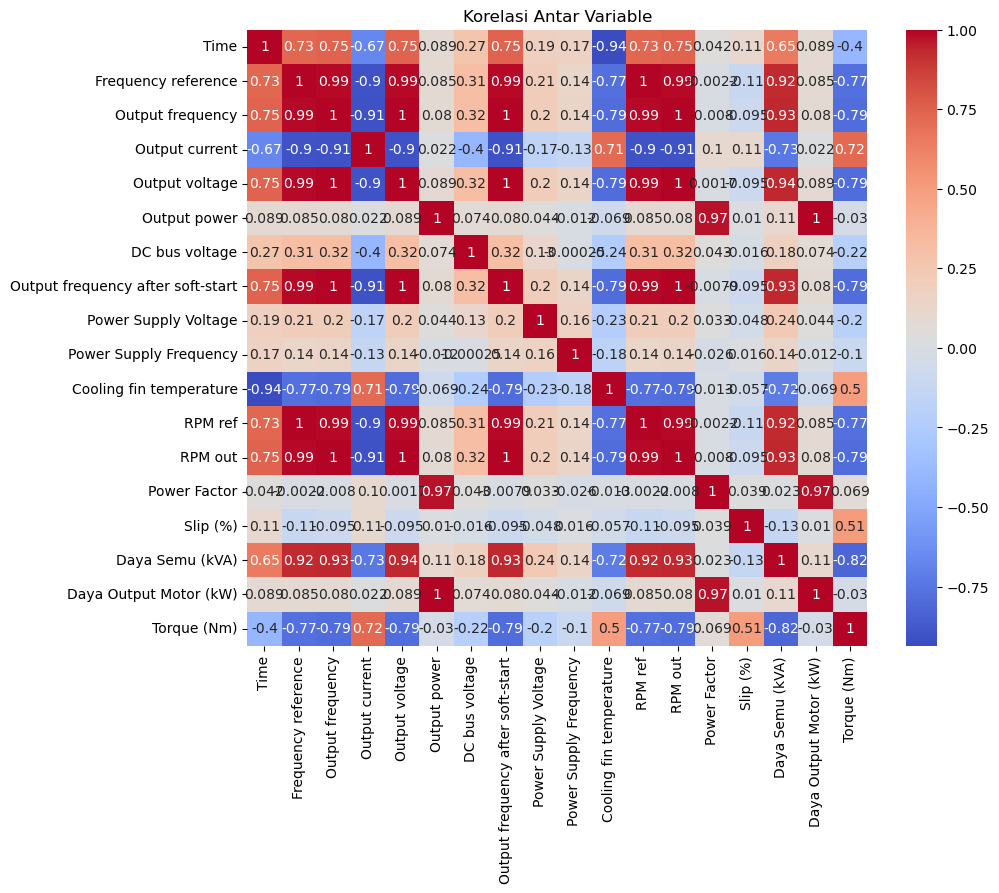

In [47]:
# Menghapus kolom yang memiliki nilai konstan dan yang hanya berisi 0 dan 1
filtered_cols = [col for col in train.columns
                 if train[col].nunique() > 1 and not set(train[col].unique()).issubset({0, 1})]

filtered_train = train[filtered_cols]

# Menghitung korelasi dan menampilkan heatmap
corr = filtered_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variable')
plt.show()

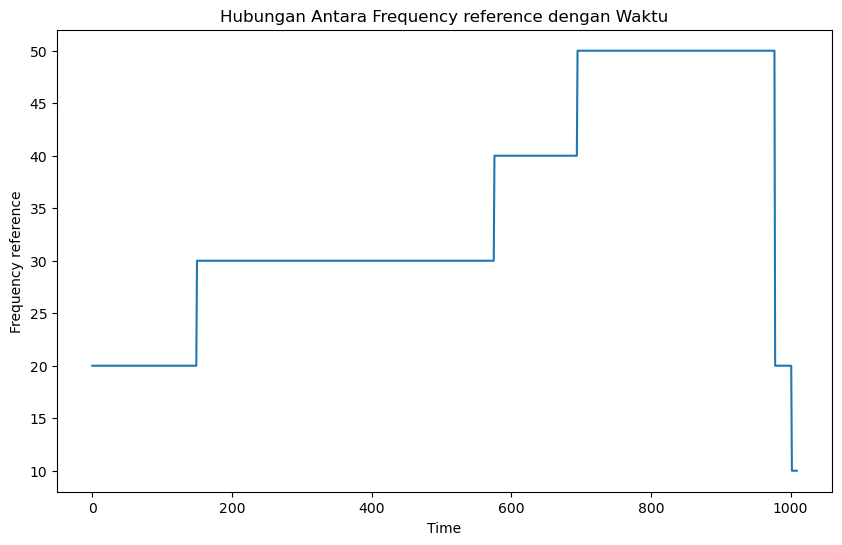

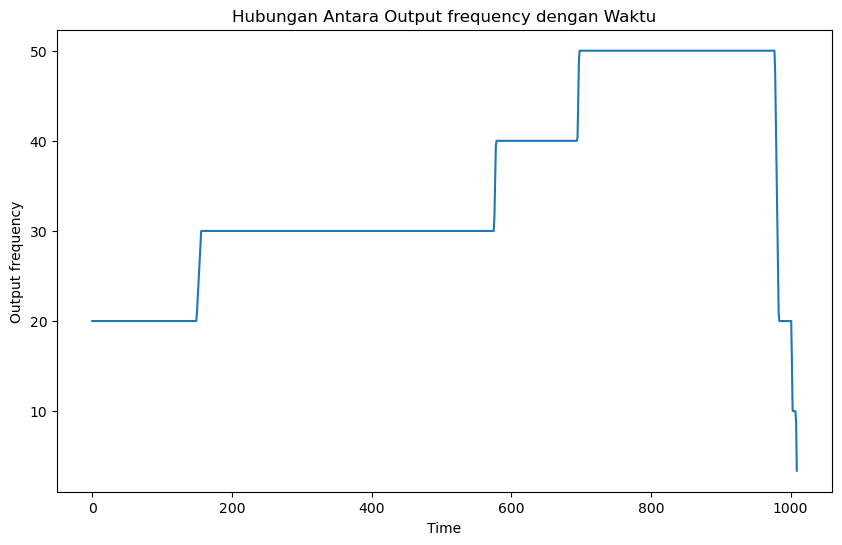

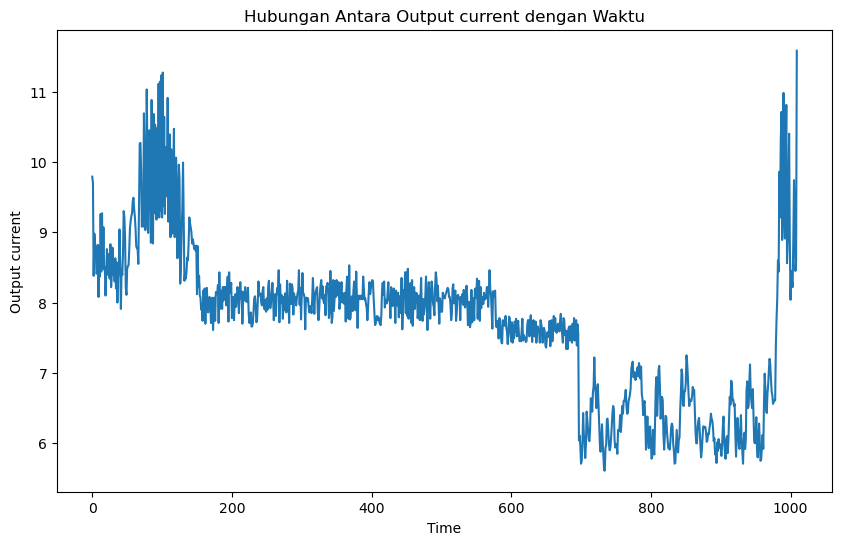

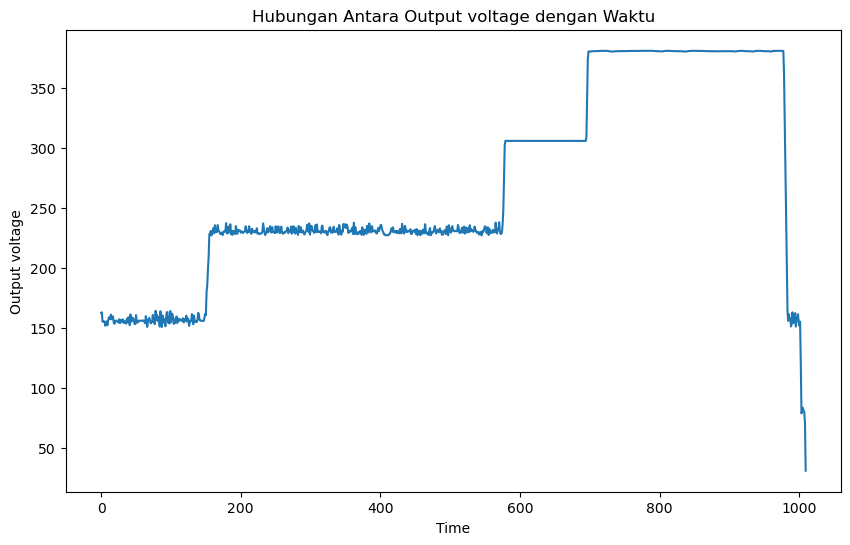

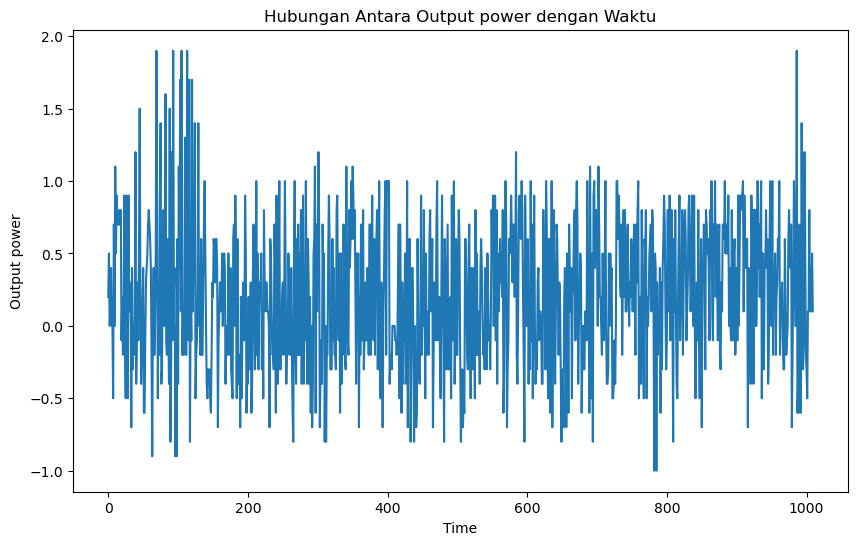

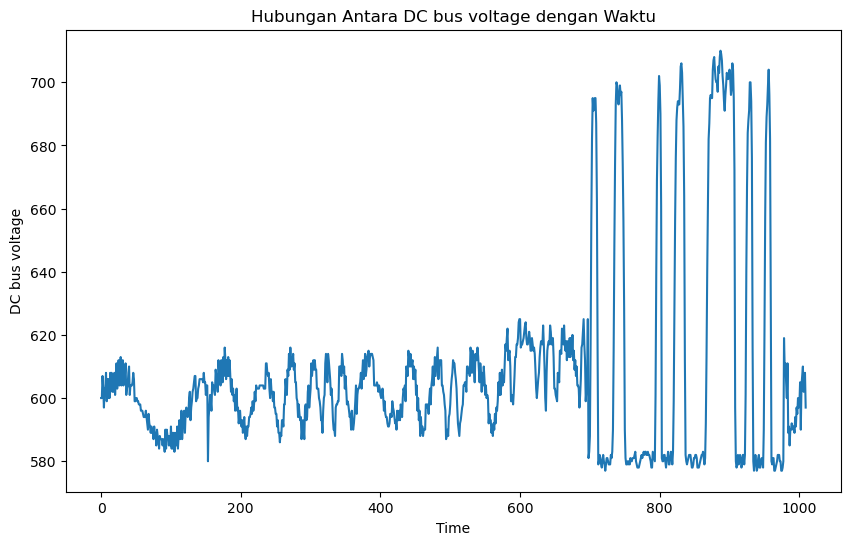

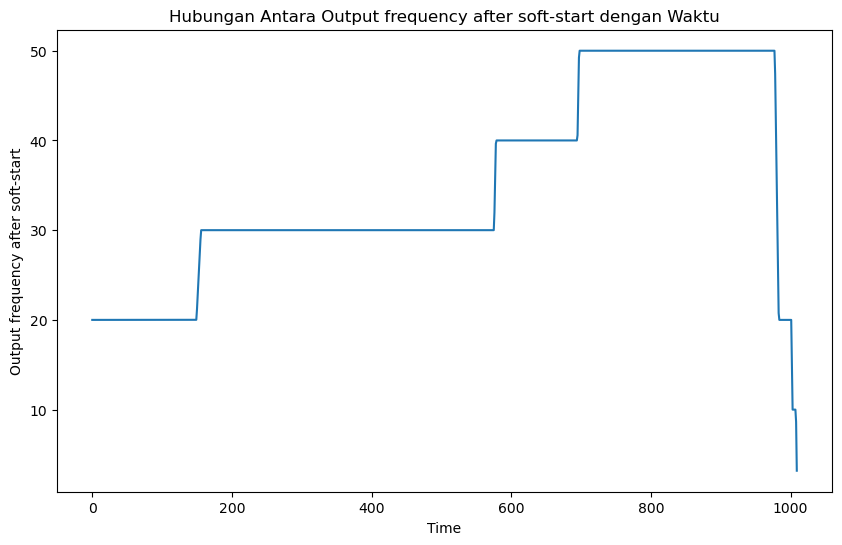

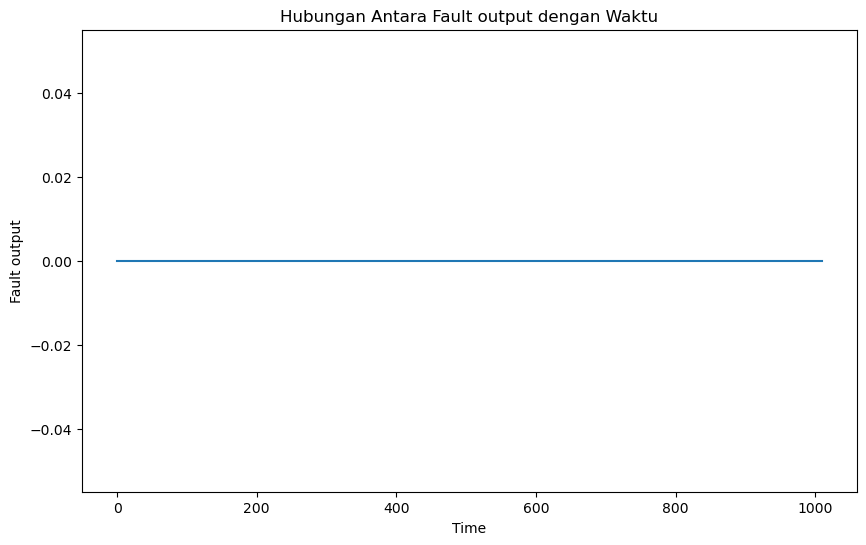

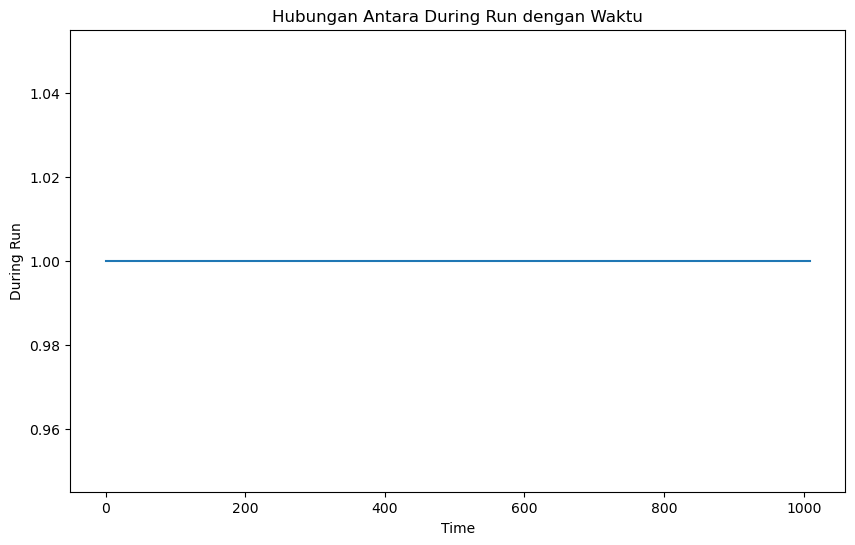

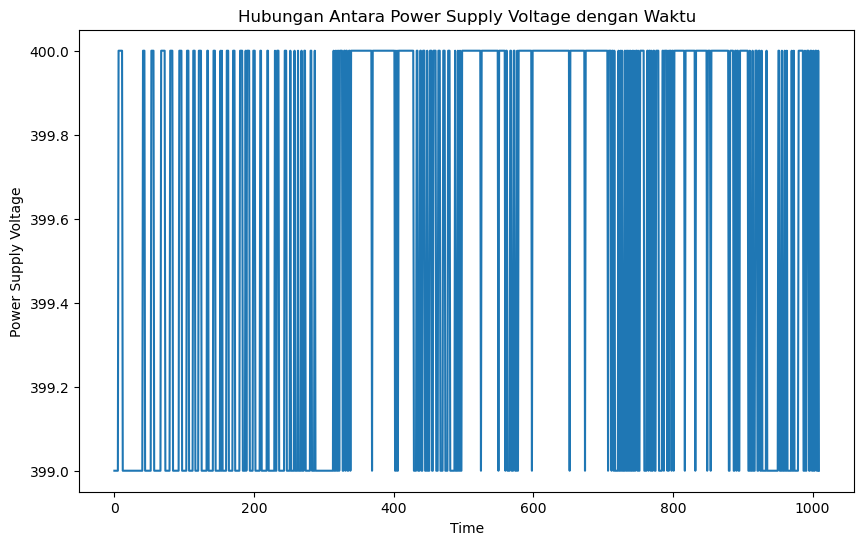

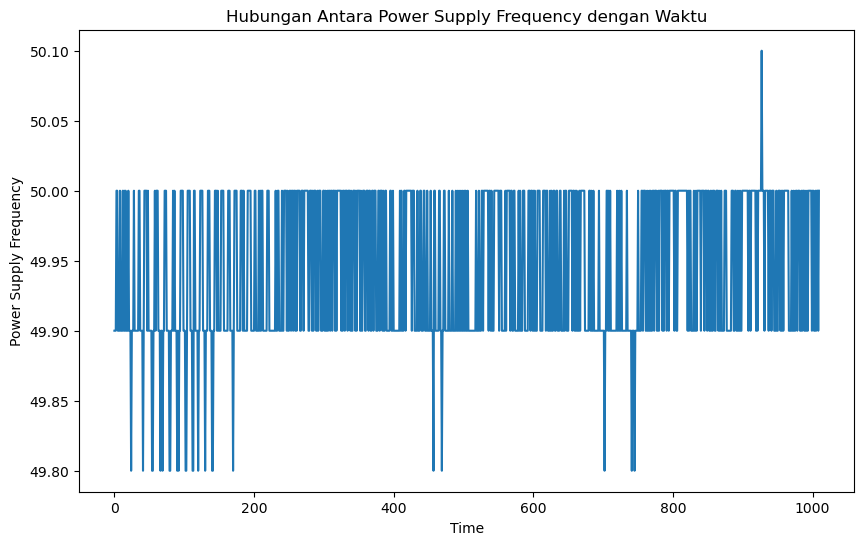

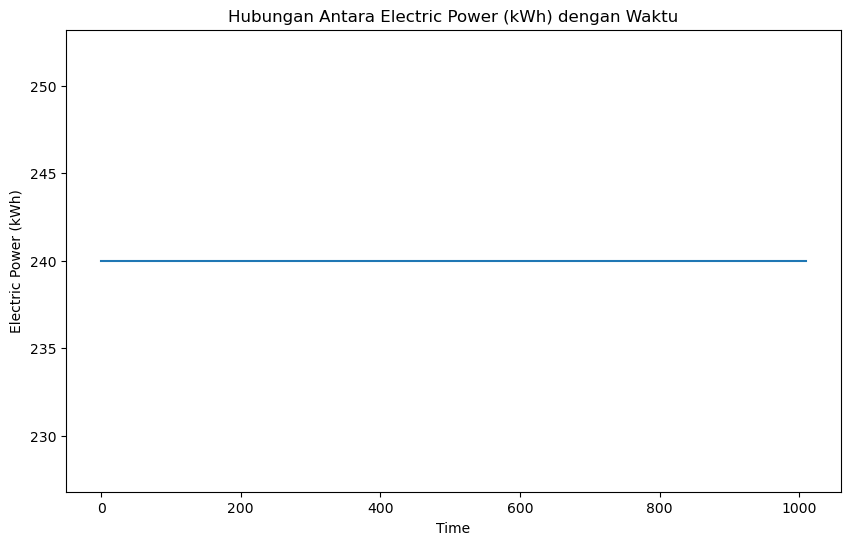

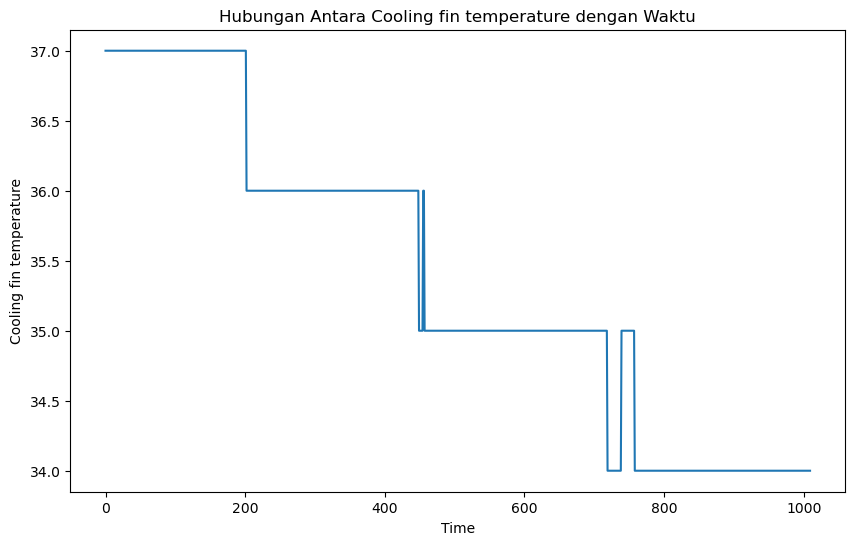

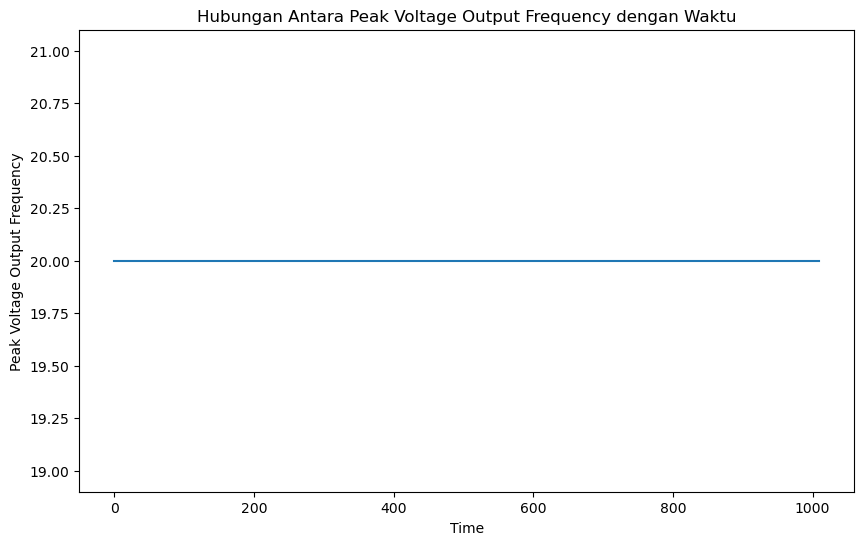

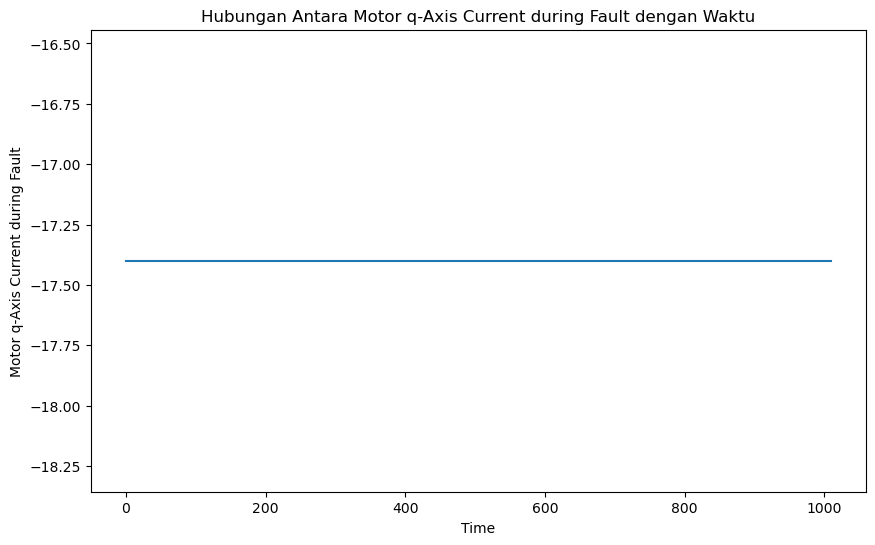

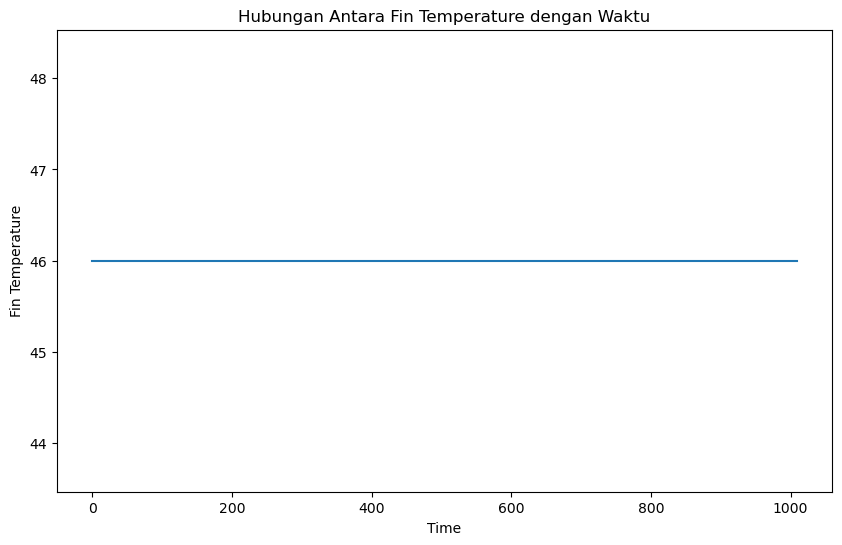

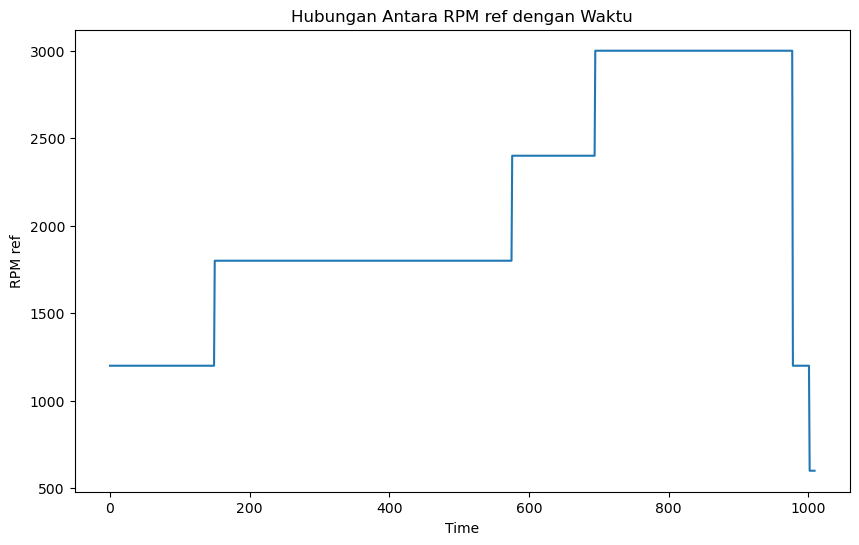

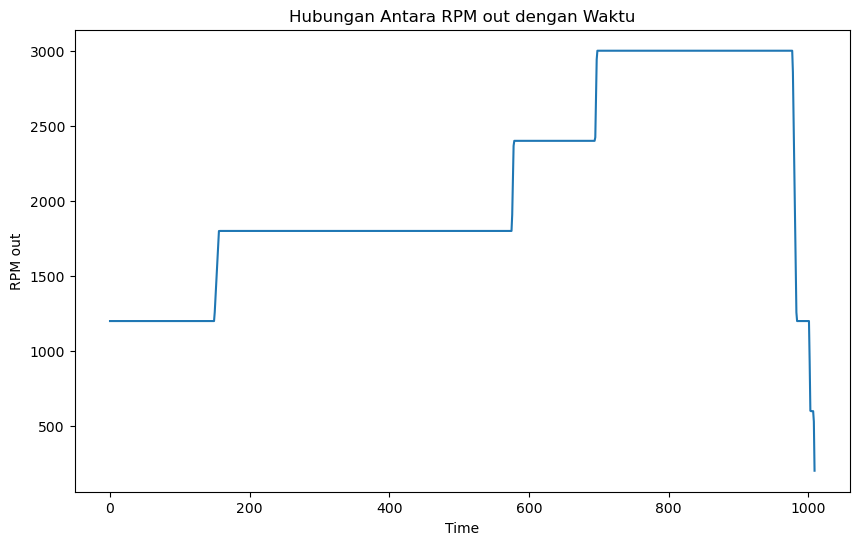

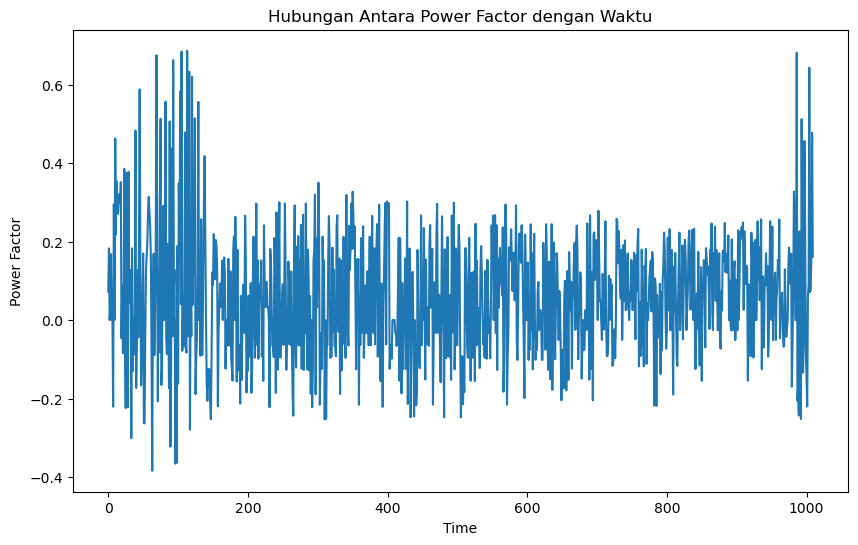

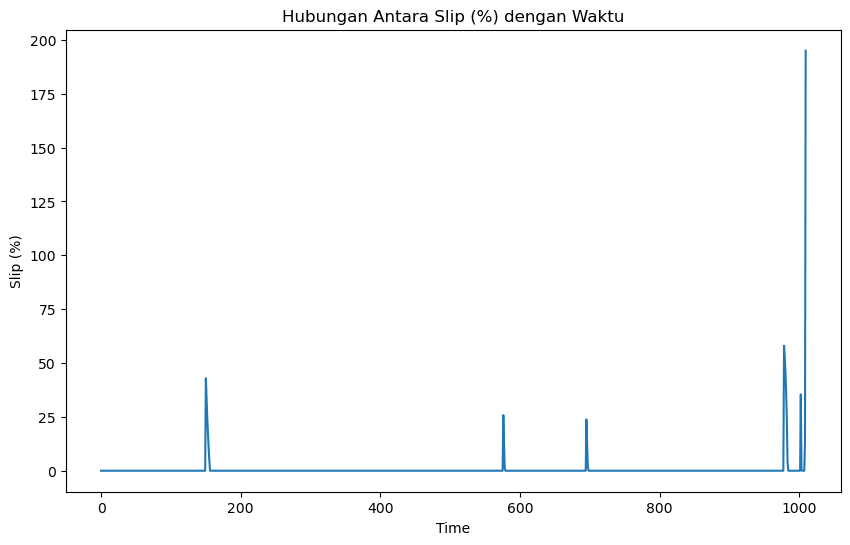

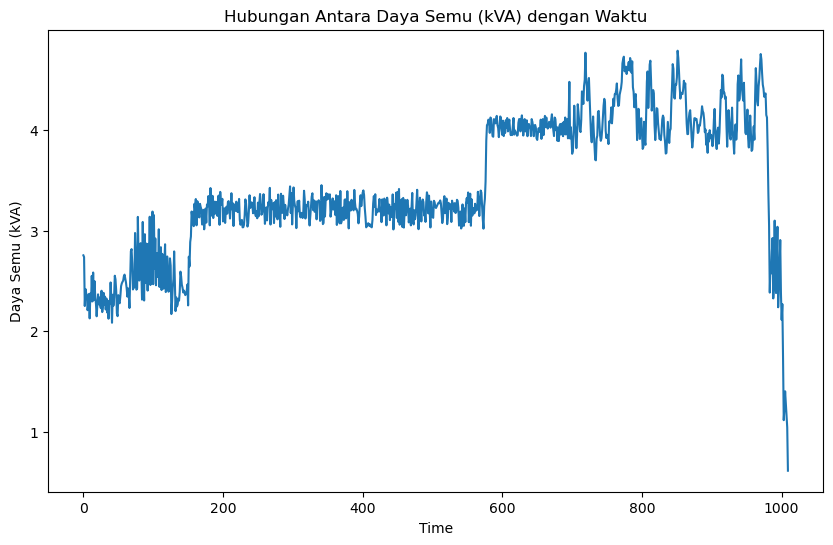

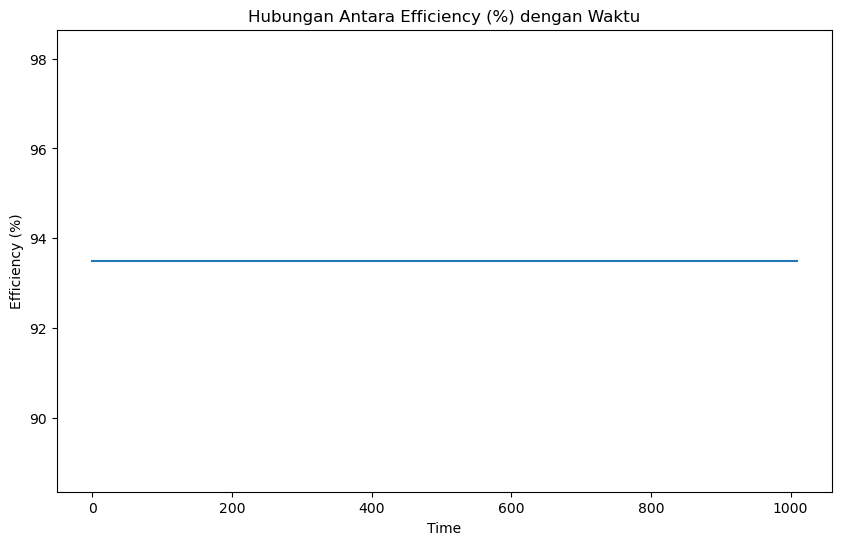

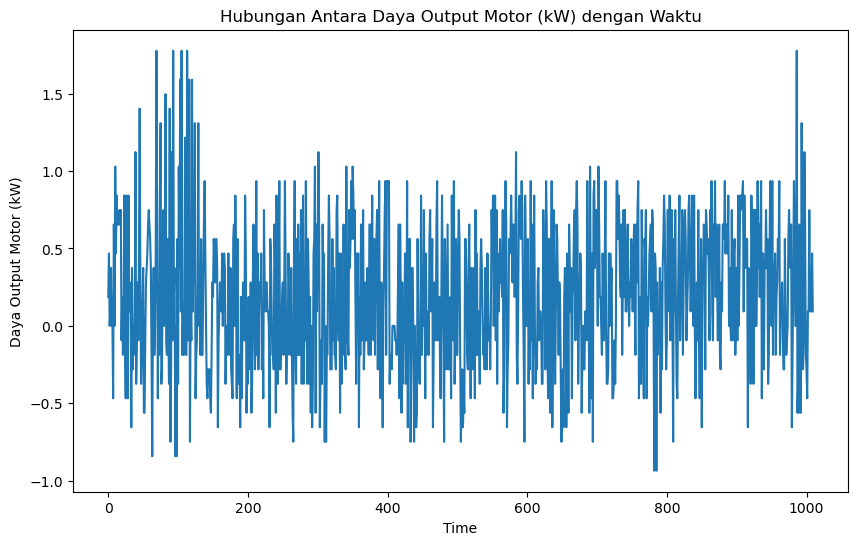

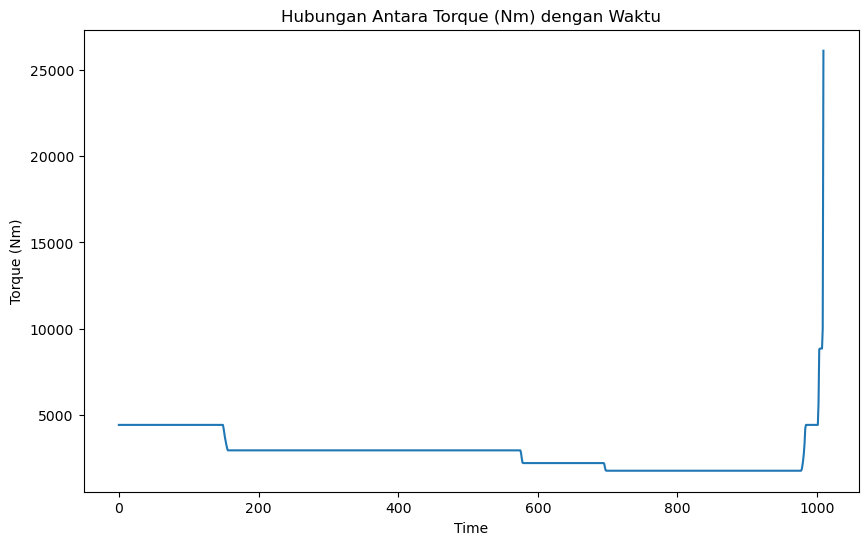

In [49]:
# Hubungan Antara Waktu dengan Variable Lain
for col in train.columns:
    if col != "Time":
        plt.figure(figsize=(10, 6))
        plt.plot(train.index, train[col], label=col)
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.title(f"Hubungan Antara {col} dengan Waktu")
        plt.show()